# Tuning results from K-means models
Parameters tested
1. K
2. num_kernels

In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from param import *

sns.set_theme(style="whitegrid")
output_dir = ParamDir().output_dir
datalist = ParamDir().data_path_list

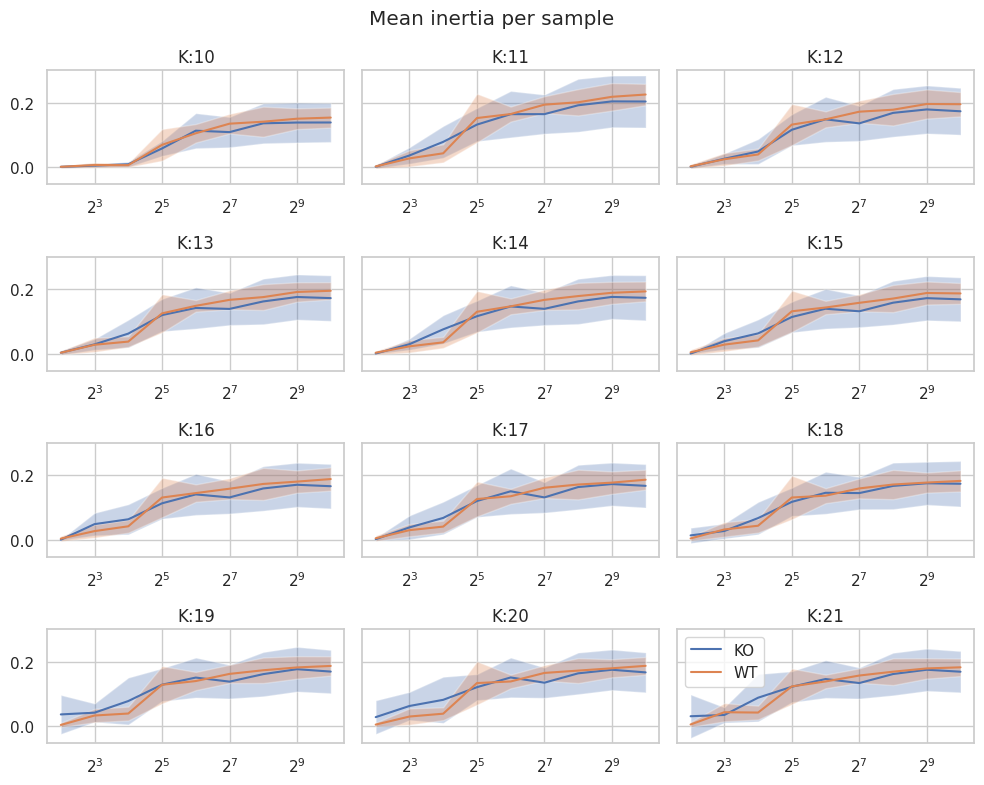

In [2]:
result_org = []
for data_dir in datalist:
    data_name = str(data_dir).split('/')[-1]
    with open(ParamDir().output_dir/data_name/(f"tsc_tuning_k_means_large_scale.pickle"),"rb") as f:
        result_all = pickle.load(f)
    for result in result_all:
        if "KO" in data_name:
            result_org.append((result['estimator'].inertia_/result['X_shape'][0], result["K"], result["num_kernels"], "KO"))
        else:
            result_org.append((result['estimator'].inertia_/result['X_shape'][0], result["K"], result["num_kernels"], "WT"))

df = pd.DataFrame(result_org, columns=["scores", "K", "num_kernels", "mouse_type"])

fig, axes = plt.subplots(figsize=(10,8),nrows=4, ncols=3, sharey=True, tight_layout=True)
axes = axes.ravel()
[ax.set_xscale("log", base=2) for ax in axes]

for i, K_value in enumerate(df["K"].unique()):
    ax = axes[i]
    xx = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].mean().loc["KO"]
    KO_std = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].std().loc["KO"]
    ax.plot(xx, label="KO")
    ax.fill_between(xx.index, xx-KO_std, xx+KO_std, alpha=.3)

    xx = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].mean().loc["WT"]
    WT_std = df[df["K"]==K_value].groupby(["mouse_type", "num_kernels"])["scores"].std().loc["WT"]
    ax.plot(xx, label="WT")
    ax.fill_between(xx.index, xx-WT_std, xx+WT_std, alpha=.3)

    ax.set_title(f"K:{K_value}")

plt.suptitle("Mean inertia per sample")
plt.legend(loc="upper left")


In [3]:
result['X_shape'][0]

104